# Outlier Detection (Gaussian Toy Example)

In this notebook, we will demonstrate the basics of outlier detection in the context of anomaly detection. 
We will use simple Gaussian toy data to demonstrate the basic concepts. 

In the outlier detection version of anomaly detection, we train a model to learn what our background looks like
and then classify things as anomalous based on how 'disimilar' they look as compared to the background. 

Essentially this means we are defining events that have low probability density under the background to be anomalous. 
In this case, we are generating our own Gaussian toy data, so we know the true probability distribution of the background.
However, in realistic physics examples this is usually not the case. 
One must therefore train a machine learning model to learn the background probability distribution, or an equivalent proxy, from a sample of background events.

One common proxy used to learn the background distribution is a type of neural network called an autoencoder.
Autoencoders do not directly learn the probability distribution. Instead they are trained to take the input data, compress it down into some smaller representation
and decompress it back out to recover the original inputs. The idea is that by forcing the model to learn to compress the data, it will force it to learn its underlying structure.
If the model is trained only on background events, it should hopefully learn how to do this compression task for background events but not for signal events.
Therefore, there should be a larger difference between the model input and output on signal events. 
This difference, called the reconstruction loss, can therefore be used as an anomaly score.

Note that unlike weak supervision, we expect this type model to always be worse than a supervised classifier because it never sees signal events during the training.
However, it can usuaully be trained in an easier fashion, (because one only needs to find a sample of background events) and has a stable performance instead of varying depending on the amount of signal present. 

In [1]:
import sys, copy
from os.path import exists, join, dirname, realpath

import numpy as np
import scipy
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# adding parent directory to path
parent_dir = dirname(realpath(globals()["_dh"][0]))
sys.path.append(parent_dir)

from sk_cathode.generative_models.autoencoder import Autoencoder
from sk_cathode.classifier_models.neural_network_classifier import NeuralNetworkClassifier
from sk_cathode.utils.evaluation_functions import plot_roc_and_sic

In [2]:
plt.style.use('dark_background')

In [3]:
#Pick the dimensionality of our dataset
n_dim = 10 #How many total dimensions of our data
n_signal_dim = 2 #How many dimensions of our signal are different from background


#Background is multi-dim Gaussian with zero mean, diagonal covariance of one
bkg_means = np.array([0.]*n_dim)
bkg_vars = np.ones(n_dim)
bkg_cov = np.diag(bkg_vars)
bkg_pdf = scipy.stats.multivariate_normal(bkg_means, bkg_cov)


#Signal is multi-dim Gaussian centered at 1 for 'signal like dimensions and 0 for the bkg-like dimensions
sig_means = np.array([2.5] * n_signal_dim + [0.] * (n_dim - n_signal_dim))
sig_vars = np.array(n_signal_dim * [0.1] + [1.0]* (n_dim - n_signal_dim))
sig_cov = np.diag(sig_vars)
sig_pdf = scipy.stats.multivariate_normal(sig_means, sig_cov)


In [4]:
#Data for training of autoencoder classifer
n_bkg = 100000
bkg_events_train = bkg_pdf.rvs(size=n_bkg)


#Data for training of supervised classifer
n_sup = 10000
sig_events_sup = sig_pdf.rvs(size=n_sup)
bkg_events_sup = bkg_pdf.rvs(size=n_sup)

x_sup = np.append(sig_events_sup, bkg_events_sup, axis = 0)
y_sup = np.append(np.ones(n_sup, dtype=np.int8), np.zeros(n_sup, dtype=np.int8))

x_sup, y_sup = shuffle(x_sup, y_sup, random_state=42)
x_sup_train, x_sup_val, y_sup_train, y_sup_val = train_test_split(x_sup, y_sup, test_size=0.2, random_state=42)

#Data for testing
n_test = 50000
sig_events_test = sig_pdf.rvs(size=n_test//10)
bkg_events_test = bkg_pdf.rvs(size=n_test)

x_test = np.append(sig_events_test, bkg_events_test, axis=0)
y_test = np.append(np.ones(n_test//10, dtype=np.int8), np.zeros(n_test, dtype=np.int8))



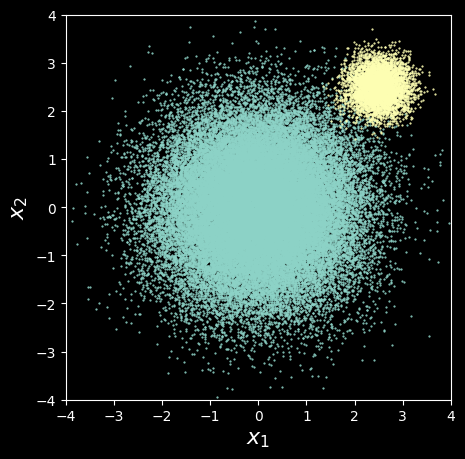

In [5]:
# Simple scatter plot of the first two dimensions of our data, background is in blue, signal is in orange
plt.figure(figsize = (5,5))
plt.scatter(bkg_events_test[:,0],bkg_events_test[:,1],s=0.3,color='C0')
plt.scatter(sig_events_test[:,0],sig_events_test[:,1],s=0.3,color='C1')
plt.gca().set_aspect(1.)
plt.xlabel(r'$x_1$',fontsize=16)
plt.ylabel(r'$x_2$',fontsize=16)
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.show()


In [6]:
#AE model

#Pick size of compressed representation (latent)
latent_size = 4
layers = [n_dim, 32, 16, latent_size, 16, 32, n_dim]

ae_model = Autoencoder(n_inputs=n_dim, 
                       layers=layers, 
                       val_split=0.1,
                       early_stopping=True, 
                       epochs=100, verbose=True)
ae_model.fit(bkg_events_train)


Epoch: 0


Train loss: 0.696005: 100%|██████████| 100000/100000 [00:02<00:00, 43388.74it/s]


Validation loss: 0.6031512432848402

Epoch: 1


Train loss: 0.599669: 100%|██████████| 100000/100000 [00:02<00:00, 46409.18it/s]


Validation loss: 0.591848996594129

Epoch: 2


Train loss: 0.576782: 100%|██████████| 100000/100000 [00:02<00:00, 49004.29it/s]


Validation loss: 0.5609037131071091

Epoch: 3


Train loss: 0.547657: 100%|██████████| 100000/100000 [00:02<00:00, 48063.26it/s]


Validation loss: 0.5326716103364745

Epoch: 4


Train loss: 0.516913: 100%|██████████| 100000/100000 [00:02<00:00, 48506.98it/s]


Validation loss: 0.4974993178454202

Epoch: 5


Train loss: 0.479694: 100%|██████████| 100000/100000 [00:02<00:00, 46601.39it/s]


Validation loss: 0.45740616900841596

Epoch: 6


Train loss: 0.439542: 100%|██████████| 100000/100000 [00:02<00:00, 46241.27it/s]


Validation loss: 0.42227926667389054

Epoch: 7


Train loss: 0.413183: 100%|██████████| 100000/100000 [00:02<00:00, 42084.51it/s]


Validation loss: 0.40412762620107595

Epoch: 8


Train loss: 0.399147: 100%|██████████| 100000/100000 [00:02<00:00, 44561.42it/s]


Validation loss: 0.3930386183283213

Epoch: 9


Train loss: 0.390117: 100%|██████████| 100000/100000 [00:02<00:00, 41810.80it/s]


Validation loss: 0.38667041920792417


Autoencoder(early_stopping=True, epochs=10, layers=[10, 32, 16, 4, 16, 32, 10],
            n_inputs=10, val_split=0.1, verbose=True)

In [7]:
#Do a quick check of the performance of the autoencoder as a classifier 

#predict_proba method computes MSE loss which we use as 'anomaly score' for each event 
y_test_ae = ae_model.predict_proba(x_test)
auc_ae = roc_auc_score(y_test, y_test_ae)

print("AE AUC %.3F" % auc_ae)

AE AUC 0.935


In order to gauge how well our autoencoder is doing we can compare it to serval benchmarks.

First we can see how well evaluating the true background pdf would do. We expect this to to similar to a well performing autoencder
We also train a supervised classifier and compute the likelihood ratio. We expect these to be sgnificantly better than the outlier detection methods

In [8]:
#Do a quick check of the performance of the true bkg pdf as a classifier 
x_test_bkg_pdf = bkg_pdf.pdf(x_test)
#One over bkg probability as outlier score 
y_test_pdf = 1./x_test_bkg_pdf

auc_pdf = roc_auc_score(y_test, y_test_pdf)
print("bkg PDF AUC %.3F" % auc_pdf)

bkg PDF AUC 0.952


In [9]:
#Use exact likelihood ratio to get optimal performance likelihood ratio
x_test_sig_pdf = sig_pdf.pdf(x_test)
likelihood_ratio = x_test_sig_pdf / x_test_bkg_pdf

auc_ratio = roc_auc_score(y_test, likelihood_ratio)
print("likelihood ratio AUC %.3F" % auc_ratio)

bkg PDF AUC 1.000


In [10]:
#Train a supervised model for comparison

sup_model = NeuralNetworkClassifier(n_inputs=n_dim,
                                    early_stopping=True, epochs=50,
                                    verbose=True)
sup_model.fit(x_sup_train, y_sup_train, x_sup_val, y_sup_val)


Epoch: 0


Train loss: 0.187399: 100%|██████████| 16000/16000 [00:00<00:00, 31669.70it/s]


Validation loss: 0.03391185017244425

Epoch: 1


Train loss: 0.020717: 100%|██████████| 16000/16000 [00:00<00:00, 52305.64it/s]


Validation loss: 0.023600481014000252

Epoch: 2


Train loss: 0.015850: 100%|██████████| 16000/16000 [00:00<00:00, 52312.89it/s]


Validation loss: 0.02095667591493111

Epoch: 3


Train loss: 0.011354: 100%|██████████| 16000/16000 [00:00<00:00, 52016.65it/s]


Validation loss: 0.017599339447770035

Epoch: 4


Train loss: 0.010058: 100%|██████████| 16000/16000 [00:00<00:00, 53125.91it/s]


Validation loss: 0.02253874876669215

Epoch: 5


Train loss: 0.008470: 100%|██████████| 16000/16000 [00:00<00:00, 52595.92it/s]


Validation loss: 0.01578118936595274

Epoch: 6


Train loss: 0.009040: 100%|██████████| 16000/16000 [00:00<00:00, 51823.36it/s]


Validation loss: 0.014908405391906854

Epoch: 7


Train loss: 0.007113: 100%|██████████| 16000/16000 [00:00<00:00, 51907.62it/s]


Validation loss: 0.017346551644550345

Epoch: 8


Train loss: 0.006320: 100%|██████████| 16000/16000 [00:00<00:00, 52488.67it/s]


Validation loss: 0.015855953131904243

Epoch: 9


Train loss: 0.006574: 100%|██████████| 16000/16000 [00:00<00:00, 52383.25it/s]


Validation loss: 0.014733747975697042


NeuralNetworkClassifier(early_stopping=True, epochs=10, n_inputs=10,
                        verbose=True)

In [11]:
#Do a quick check of the performance of the supervised classifier 
y_test_sup = sup_model.predict(x_test)
auc_sup = roc_auc_score(y_test, y_test_sup)

print("Supervised AUC %.3F" % auc_sup)

Supervised AUC 1.000


/home/oamram/sk_cathode/sk_cathode/utils/evaluation_functions.py:89: RuntimeWarning: divide by zero encountered in divide
  random_bkg_rej = 1 / random_fpr
/home/oamram/sk_cathode/sk_cathode/utils/evaluation_functions.py:90: RuntimeWarning: invalid value encountered in divide
  random_sic = random_tpr / np.sqrt(random_tpr)
/home/oamram/sk_cathode/sk_cathode/utils/evaluation_functions.py:95: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tprs[i], 1./fprs[i], lw=2, label=labels[i])


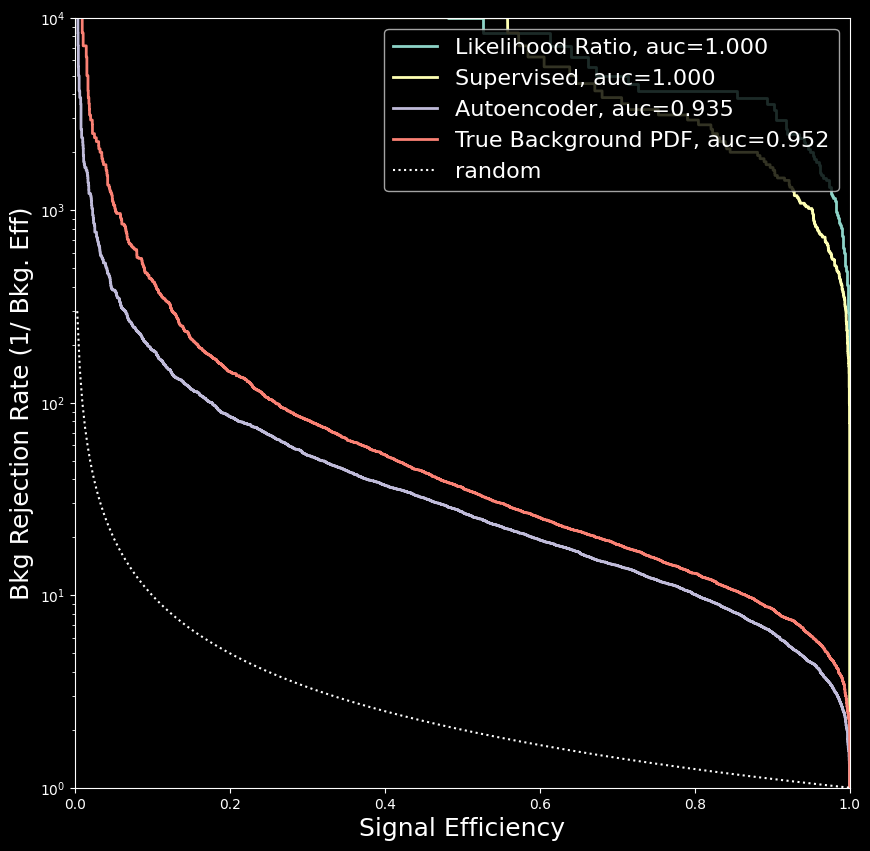

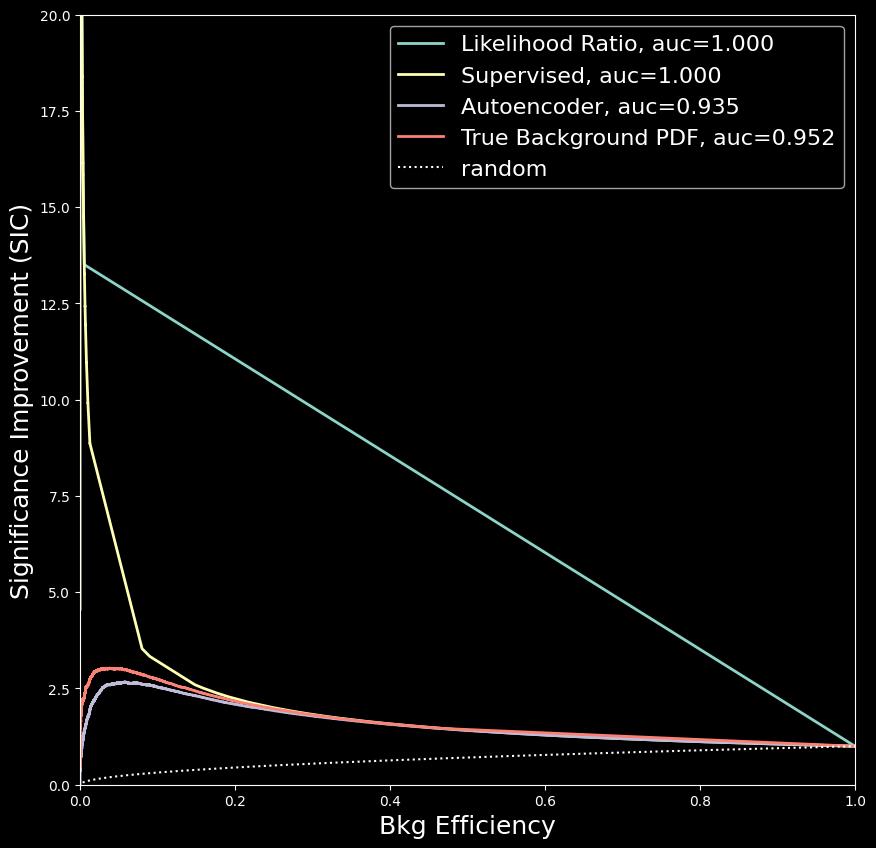

In [13]:
plot_roc_and_sic(y_test,
                 [likelihood_ratio, y_test_sup, y_test_ae, y_test_pdf],
                 labels = ['Likelihood Ratio', 'Supervised', 'Autoencoder',  'True Background PDF'])
plt.show()

We can see that the outlier detection methods, either based on the true background PDF or the autoencoder fall below the sensitivity of a supervised classifier. 
However they both are able to successfully enhance the sensitivity to the signal, by factors greater than ~2. 
The autoencoder performance is decently close to the true background PDF, which is encouraging. 

Feel free to now play around with how the results change if you change the latent size of the autoencoder, or change the signal or background PDF's.
Perhaps you can also compare the autoencoder performance to that of weak supervision on the same dataset. 